Index(['Filename', 'Inference Time (ms)', 'Temperature (°C)', 'Used RAM (MB)',
       'CPU Usage (%)'],
      dtype='object')
Index(['Filename', 'Inference Time (ms)', 'Temperature (°C)', 'Used RAM (MB)',
       'CPU Usage (%)'],
      dtype='object')


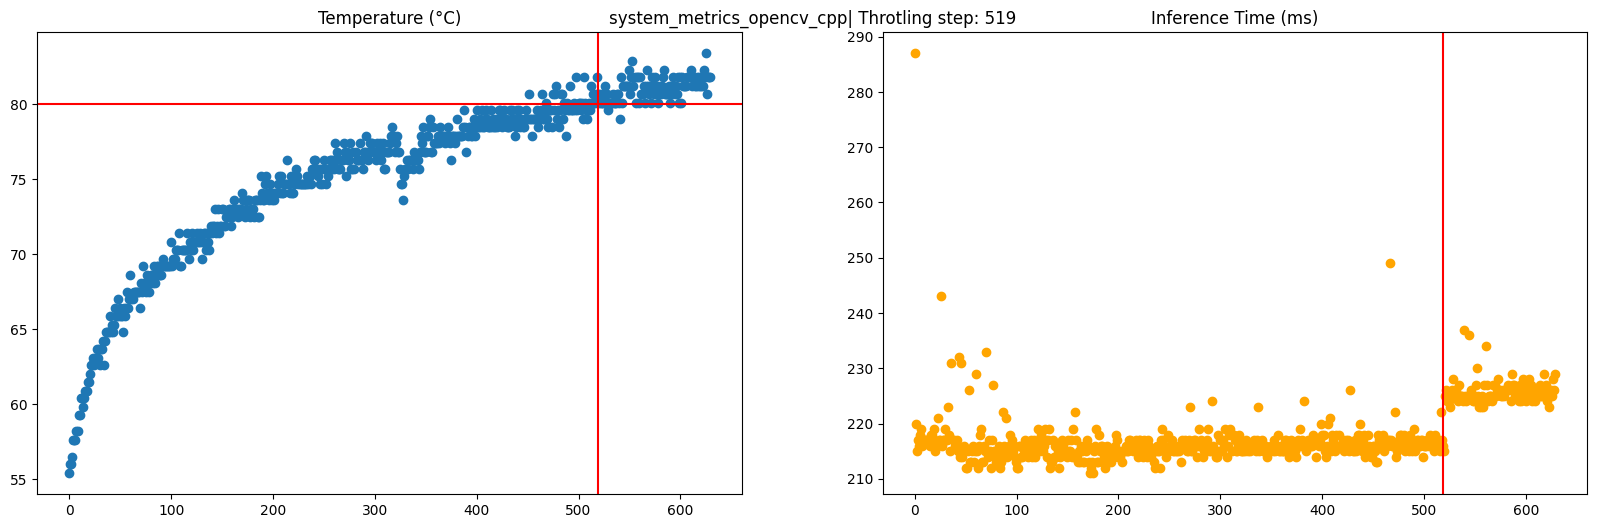

In [75]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
plt.rcParams["figure.figsize"] = (20, 6)


path = "logs/system_metrics_opencv_cpp.csv"
df = pd.read_csv(path)
print(df.columns)

if 'Timestamp' in df.columns:
    df.drop(columns=['Timestamp'], inplace=True)
    df.columns = ['Filename', 'Inference Time (ms)', 'Used RAM (MB)',  'CPU Usage (%)', 'Temperature (°C)',]
print(df.columns)

def plot_inference_temperature(df):
    step_throttling = df["Temperature (°C)"].rolling(40).mean().ge(80).idxmax()
    plt.title(f"{Path(path).stem}| Throtling step: " + str(step_throttling))
    plt.axis('off')
    
    plt.subplot(1, 2, 1)
    plt.title("Temperature (°C)")
    plt.scatter(x=df.index, y=df[["Temperature (°C)"]])
    
    if step_throttling:
        plt.axhline(y = 80, color = 'r', linestyle = '-') 
        plt.axvline(x = step_throttling, color = 'r', linestyle = '-') 

    
    plt.subplot(1, 2, 2)
    plt.title('Inference Time (ms)')
    if step_throttling:
        plt.axvline(x = step_throttling, color = 'r', linestyle = '-') 
    plt.scatter(x=df.index, y=df[['Inference Time (ms)']], color='orange', )
    
    return step_throttling

throthling = plot_inference_temperature(df)

In [5]:
df["Temperature (°C)"].values[:100]

array([56.5, 57.1, 56.5, 57.1, 57.1, 57.6, 59.8, 58.7, 58.7, 59.8, 59.3,
       59.3, 59.3, 58.2, 61.5, 59.3, 60.4, 59.3, 60.4, 60.4, 60.4, 60.9,
       60.4, 60.4, 60.9, 60.9, 62. , 61.5, 60.9, 61.5, 62.6, 62. , 60.9,
       62. , 62. , 62.6, 62. , 62. , 62. , 62.6, 63.7, 63.1, 63.1, 62. ,
       61.5, 62.6, 63.1, 62.6, 63.7, 64.2, 63.1, 63.1, 63.7, 63.7, 63.1,
       63.1, 65.3, 63.1, 63.7, 63.1, 63.7, 64.2, 64.2, 63.7, 63.7, 64.8,
       63.7, 63.1, 64.2, 64.2, 64.8, 65.3, 63.7, 63.7, 65.9, 65.3, 65.9,
       64.8, 65.3, 64.8, 65.3, 64.8, 63.7, 65.3, 64.8, 65.3, 66.4, 65.3,
       67.5, 64.2, 64.8, 65.3, 64.2, 66.4, 65.9, 65.9, 65.9, 66.4, 65.3,
       65.9])

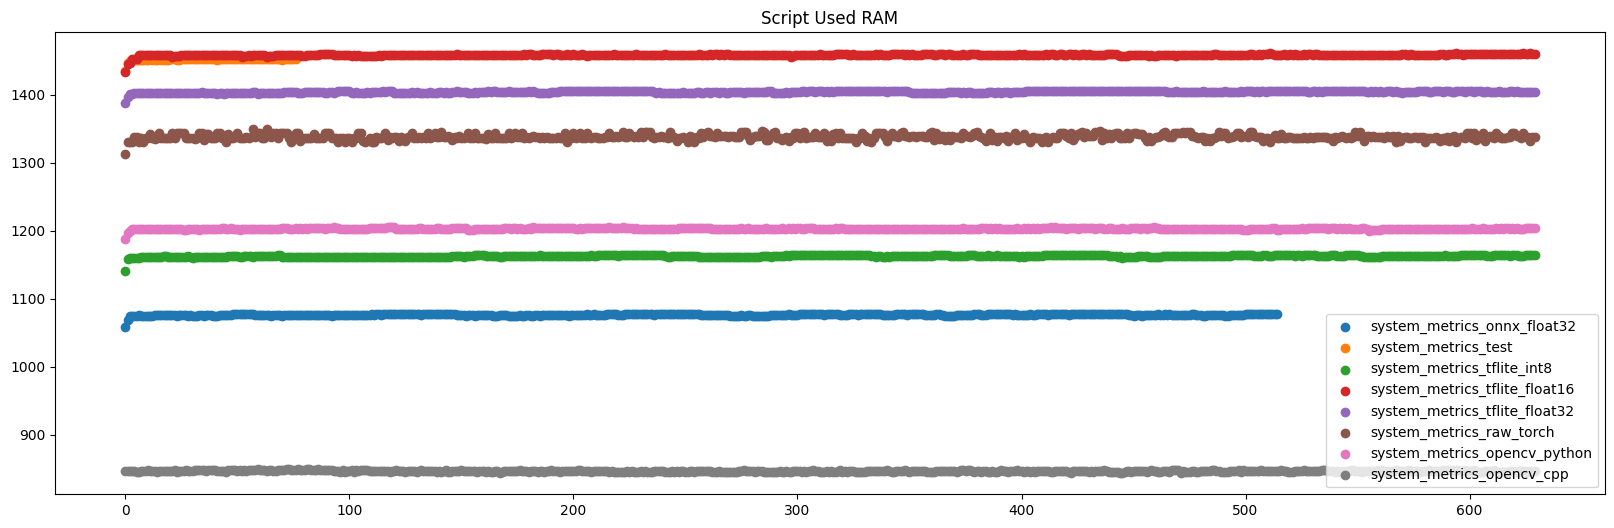

In [79]:
from pathlib import Path

plt.title('Script Used RAM')

for f in  Path('logs').glob("*.csv"):
    df = pd.read_csv(f)
    # plt.axhline(df['Used RAM (MB)'].median())
    plt.scatter(df.index, df['Used RAM (MB)'].rolling(1).mean(), label = f.stem)
plt.legend()

In [1]:
import cv2
import cv2.dnn

model: cv2.dnn.Net = cv2.dnn.readNetFromONNX("/home/pi/exp/exp1/models/yolov5nu.onnx")

image = cv2.imread("/tmp/test/video/frame0001.jpg")


In [104]:
%%timeit
blob = cv2.dnn.blobFromImage(image, scalefactor=1 / 255, size=(640, 640), swapRB=True)
model.setInput(blob)

# Perform inferences
outputs = model.forward()

228 ms ± 715 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [66]:
ram, ram_labels = [], []

speed, speed_labels = [], []

for f in  sorted(Path('logs').glob("*.csv")):
    
    label = f.stem.replace("system_metrics", "")
    df = pd.read_csv(f)

    if 'Timestamp' in df.columns:
        df.drop(columns=['Timestamp'], inplace=True)
        df.columns = ['Filename', 'Inference Time (ms)', 'Used RAM (MB)',  'CPU Usage (%)', 'Temperature (°C)',]
    step_throttling = df["Temperature (°C)"].rolling(40).mean().ge(80).idxmax()
    if step_throttling:
        before_speed = df['Inference Time (ms)'].values[:step_throttling].mean()
        after_speed = df['Inference Time (ms)'].values[step_throttling:].mean()

        before_ram = df['Used RAM (MB)'].values[:step_throttling].mean()
        after_ram = df['Used RAM (MB)'].values[step_throttling:].mean()
    else: 
        before_speed = after_speed = df['Inference Time (ms)'].values.mean()
        before_ram = after_ram =  df['Used RAM (MB)'].values.mean()



    ram.append(before_ram)
    ram_labels.append(f"before_{label}")
    ram.append(after_ram)
    ram_labels.append(f"after_{label}")

    speed.append(before_speed)
    speed_labels.append(f"before_{label}")
    speed.append(after_speed)
    speed_labels.append(f"after_{label}")
    


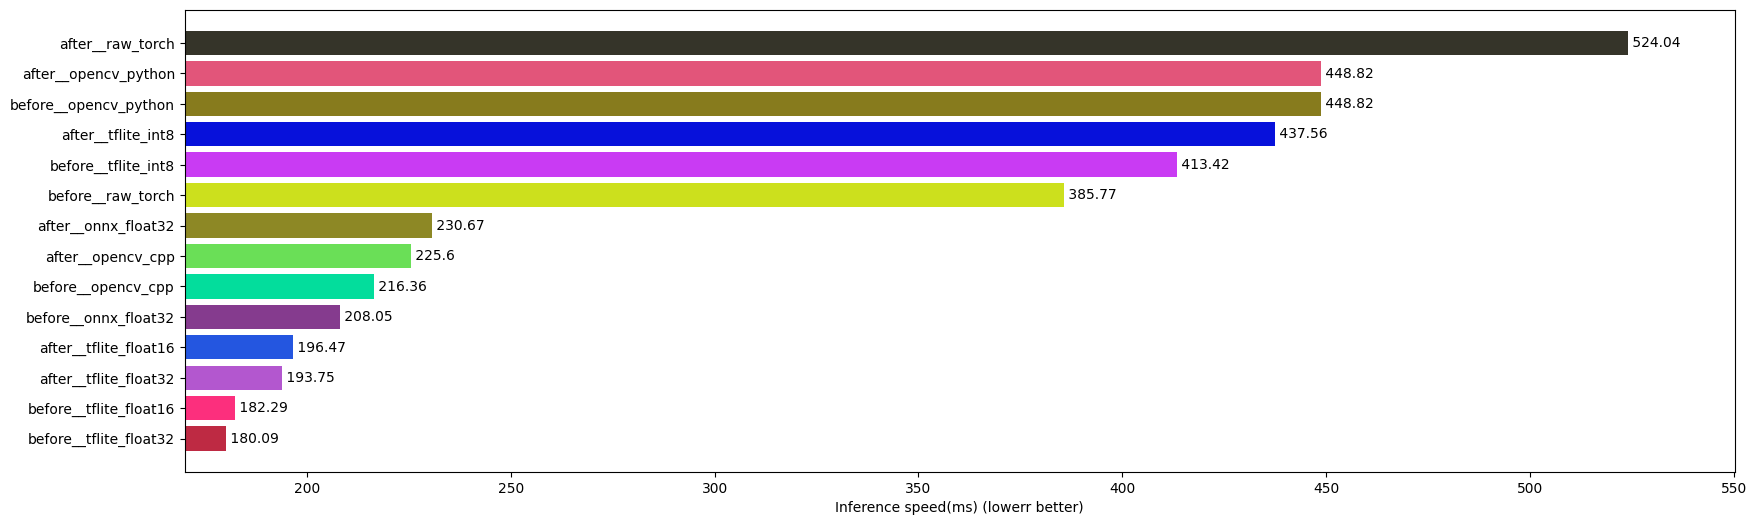

In [67]:
idxs = np.argsort(speed)
speed = np.round(np.array(speed)[idxs], 2)
speed_labels = np.array(speed_labels)[idxs]

# colors = np.random.rand(len(speed), 3)
plt.barh(speed_labels, speed, align='center', color=colors)
for index, value in enumerate(speed):
    plt.text(value, index, f' {value}', va='center')
plt.xlabel("Inference speed(ms) (lowerr better)")
plt.xlim(left=170)
plt.savefig('a.png')

Text(0.5, 0, 'Inference speed(ms) (lowerr better)')

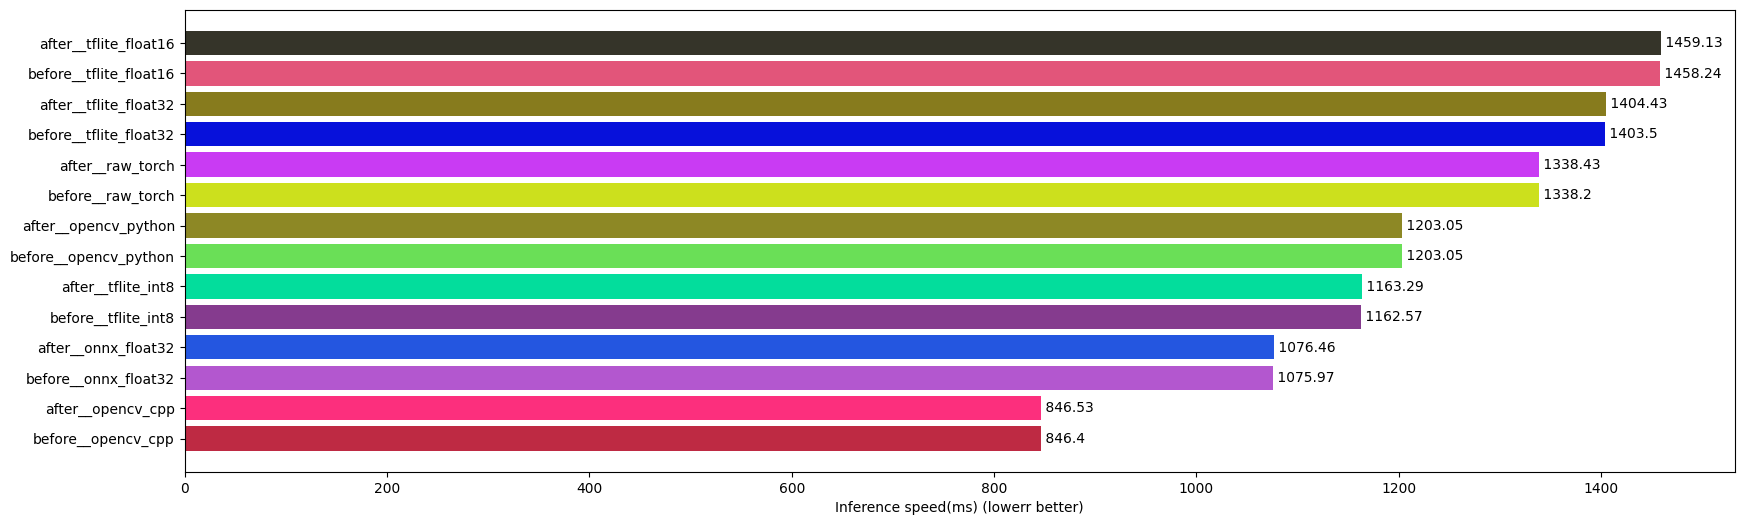

In [77]:
idxs = np.argsort(ram)
ram = np.round(np.array(ram)[idxs], 2)
ram_labels = np.array(ram_labels)[idxs]

# colors = np.random.rand(len(speed), 3)
plt.title('')
plt.barh(ram_labels, ram, align='center', color=colors)
for index, value in enumerate(ram):
    plt.text(value, index, f' {value}', va='center')
plt.xlabel("Inference speed(ms) (lowerr better)")